# Import Libraries

In [1]:
from FlagEmbedding import FlagModel
from sentence_transformers import SentenceTransformer,util

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report,confusion_matrix

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import joblib

# Functions

### Read datasets function

In [2]:
# Read a single Dataset File
def read_dataset(file_path):
    if file_path.lower().endswith('.csv'):
        dataset = pd.read_csv(file_path)
    elif file_path.lower().endswith('.xlsx'):
        dataset = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format. Please provide a .csv or .xlsx file.")
    
    dataset   = np.array(dataset)
    data_train, data_test     = train_test_split(dataset, test_size=0.2, random_state=100)

    x_train, y_train   = (data_train[:,:-1]), (data_train[:,-1]).astype("int32")
    x_test, y_test     = (data_test[:,:-1]), (data_test[:,-1]).astype("int32")           
    x_train, x_test    = x_train.squeeze(), x_test.squeeze()

    return x_train, x_test, y_train, y_test


# If you have Train and Test Datasets separate
def read_train_test_dataset(train_data, test_data):
    if train_data.lower().endswith('.csv') and test_data.lower().endswith('.csv'):
        train_data = pd.read_csv(train_data)
        test_data = pd.read_csv(test_data)
    elif train_data.lower().endswith('.xlsx') and test_data.lower().endswith('.xlsx'):
        train_data = pd.read_excel(train_data)
        test_data = pd.read_excel(test_data)
    else:
        raise ValueError("Unsupported file format. Please provide a .csv or .xlsx file.")
    
    train_data, test_data   = np.array(train_data), np.array(test_data)

    x_train, y_train   = (train_data[:,:-1]), (train_data[:,-1]).astype("int32")
    x_test, y_test     = (test_data[:,:-1]), (test_data[:,-1]).astype("int32")           
    x_train, x_test    = x_train.squeeze(), x_test.squeeze()

    return x_train, x_test, y_train, y_test

### Embedding Models


In [3]:
def BGE(sentences):
    model = SentenceTransformer('BAAI/bge-large-zh-v1.5')  # 20
    dataset_embedding = model.encode(sentences, normalize_embeddings=True)
    return dataset_embedding

def GTE(sentences):
    model = SentenceTransformer('thenlper/gte-large')  # 29 MTEB Rank
    dataset_embedding = model.encode(sentences, normalize_embeddings=True)
    return dataset_embedding

def UAE(sentences):
    model = SentenceTransformer("WhereIsAI/UAE-Large-V1")  # 13th UAE
    dataset_embedding = model.encode(sentences, normalize_embeddings=True)
    return dataset_embedding

def MRL(sentences):
    dimensions = 512
    model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1", truncate_dim=dimensions) # 12th MTEB rank
    dataset_embedding = model.encode(sentences, normalize_embeddings=True)
    return dataset_embedding

def ALI(sentences):
    model = SentenceTransformer('Alibaba-NLP/gte-large-en-v1.5', trust_remote_code=True) # 9 MTEB rank
    dataset_embedding = model.encode(sentences, normalize_embeddings=True)
    return dataset_embedding

def MUL(sentences):
    model = SentenceTransformer('intfloat/multilingual-e5-large-instruct')  # 17th Multilingual-E5-large-instruct
    dataset_embedding = model.encode(sentences, normalize_embeddings=True)
    return dataset_embedding

### Save model results

In [4]:
def save_results(true_label, predicted):
    report_dict = classification_report(true_label,predicted,output_dict=True)

    # Save Result Report
    save_report = pd.DataFrame(report_dict).transpose()  # Convert the report dictionary to a DataFrame
    save_report = save_report.round(3)                   # Round the values to a specific number of decimal places
    save_report = save_report.astype({'support': int})   # Convert the 'support' column to integers
    save_report.loc['accuracy', ['precision', 'recall', 'support']] = [None, None, None] # Set the accuracy row to None

    return save_report

## Classifiers 

### Random Forest 

In [5]:
def randomforest(x_train, y_train):
    classes = np.unique(y_train)
    # Create RandomForestClassifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=100)

    # Perform cross-validation
    cv_scores = cross_val_score(rf_classifier, x_train, y_train, cv=5, scoring='accuracy')               # Accuracy score
    precision_scores = cross_val_score(rf_classifier, x_train, y_train, cv=5, scoring='precision_macro') # precision score
    recall_scores = cross_val_score(rf_classifier, x_train, y_train, cv=5, scoring='recall_macro')       # Recall score
    f1_scores = cross_val_score(rf_classifier, x_train, y_train, cv=5, scoring='f1_macro')               # F1-score score
    y_pred = cross_val_predict(rf_classifier, x_train, y_train, cv=5)                                    # Get predictions
    conf_matrix = confusion_matrix(y_train, y_pred, labels=classes)                                                      # Compute combined CM

    # Train the model
    rf_classifier.fit(x_train, y_train)
    header = np.array(["Accuracy", "Precision", "Recall", "F1-score"])
    result_matrix =np.vstack((cv_scores,precision_scores,recall_scores,f1_scores)).T
    
    # Average across all folds
    mean_accuracy = np.mean(result_matrix[0:, 0], dtype=np.float64)
    mean_precision = np.mean(result_matrix[0:, 1], dtype=np.float64)
    mean_recall = np.mean(result_matrix[0:, 2], dtype=np.float64)
    mean_f1 = np.mean(result_matrix[0:, 3], dtype=np.float64)
    mean_array = np.hstack((mean_accuracy, mean_precision,mean_recall, mean_f1))

    # Combine the header with the result matrix
    result_matrix_with_header = np.vstack([header, result_matrix, mean_array])
    result_matrix_with_header = pd.DataFrame(result_matrix_with_header)

    return rf_classifier, result_matrix_with_header, conf_matrix

### XGBoost 

In [6]:
def XGBoost(x_train, y_train, num_class):
    classes = np.unique(y_train)
    # Create an XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=num_class, random_state=100)

    # Perform cross-validation
    cv_scores = cross_val_score(xgb_classifier, x_train, y_train, cv=5, scoring='accuracy')
    precision_scores = cross_val_score(xgb_classifier, x_train, y_train, cv=5, scoring='precision_macro') # precision score
    recall_scores = cross_val_score(xgb_classifier, x_train, y_train, cv=5, scoring='recall_macro')       # Recall score
    f1_scores = cross_val_score(xgb_classifier, x_train, y_train, cv=5, scoring='f1_macro')               # F1-score score
    y_pred = cross_val_predict(xgb_classifier, x_train, y_train, cv=5)                                    # Get predictions
    conf_matrix = confusion_matrix(y_train, y_pred, labels=classes)                                                      # Compute combined CM

    # Train the model
    xgb_classifier.fit(x_train, y_train)

    header = np.array(["Accuracy", "Precision", "Recall", "F1-score"])
    result_matrix =np.vstack((cv_scores,precision_scores,recall_scores,f1_scores)).T

    # Average across all folds
    mean_accuracy = np.mean(result_matrix[0:, 0], dtype=np.float64)
    mean_precision = np.mean(result_matrix[0:, 1], dtype=np.float64)
    mean_recall = np.mean(result_matrix[0:, 2], dtype=np.float64)
    mean_f1 = np.mean(result_matrix[0:, 3], dtype=np.float64)
    mean_array = np.hstack((mean_accuracy, mean_precision,mean_recall, mean_f1))

    # Combine the header with the result matrix
    result_matrix_with_header = np.vstack([header, result_matrix, mean_array])
    result_matrix_with_header = pd.DataFrame(result_matrix_with_header)

    return xgb_classifier, result_matrix_with_header, conf_matrix

### Predict Function

In [7]:
def prediction(classifier, x_test, y_test):
    y_pred = classifier.predict(x_test)

    # Evaluate the model
    class_report = classification_report(y_test, y_pred)

    return y_pred, class_report

# Five class Classification

In [8]:
# Read dataset 
humor_5class_path = "datasets/Humour_style.xlsx" 
x_train_5, x_test_5, y_train_5, y_test_5 = read_dataset(humor_5class_path)

#### Embedding Text

In [10]:
# BGE Embedding Model
x_train_5_bge, x_test_5_bge = BGE(x_train_5), BGE(x_test_5)

# GTE Embedding Model
x_train_5_gte, x_test_5_gte = GTE(x_train_5), GTE(x_test_5)

# UAE Embedding Model
x_train_5_uae, x_test_5_uae = UAE(x_train_5), UAE(x_test_5)

# MRL Embedding Model
x_train_5_mrl, x_test_5_mrl = MRL(x_train_5), MRL(x_test_5)

# ALI Embedding Model
x_train_5_ali, x_test_5_ali = ALI(x_train_5), ALI(x_test_5)

# MUL Embedding Model
x_train_5_mul, x_test_5_mul = MUL(x_train_5), MUL(x_test_5)

##### Random Forest Training, Validation and Prediction

In [23]:
# Train, CrossValidation and Prediction using Random Forest
RF_bge_classifier5, RF_bge_cv_scores5,RF_bge_cm5 = randomforest(x_train_5_bge,y_train_5)
RF_bge_y_pred5, RF_bge_class_report5             = prediction(RF_bge_classifier5,x_test_5_bge, y_test_5)

RF_gteclassifier5, RF_gte_cv_scores5,RF_gte_cm5  = randomforest(x_train_5_gte, y_train_5)
RF_gte_y_pred5, RF_gte_class_report5             = prediction(RF_gteclassifier5, x_test_5_gte, y_test_5)

RF_uae_classifier5, RF_uae_cv_scores5,RF_uae_cm5 = randomforest(x_train_5_uae,y_train_5)
RF_uae_y_pred5, RF_uae_class_report5             = prediction(RF_uae_classifier5,x_test_5_uae, y_test_5)

RF_mrl_classifier5, RF_mrl_cv_scores5,RF_mrl_cm5 = randomforest(x_train_5_mrl,y_train_5)
RF_mrl_y_pred5, RF_mrl_class_report5             = prediction(RF_mrl_classifier5,x_test_5_mrl, y_test_5)

RF_ali_classifier5, RF_ali_cv_scores5,RF_ali_cm5 = randomforest(x_train_5_ali,y_train_5)
RF_ali_y_pred5, RF_ali_class_report5             = prediction(RF_ali_classifier5,x_test_5_ali, y_test_5)

RF_mul_classifier5, RF_mul_cv_scores5,RF_mul_cm5 = randomforest(x_train_5_mul,y_train_5)
RF_mul_y_pred5, RF_mul_class_report5             = prediction(RF_mul_classifier5,x_test_5_mul, y_test_5)

# Save Report
RF_bge_result_5= save_results(y_test_5,RF_bge_y_pred5)
RF_bge_result_5.to_csv('models_results/RF_bge_5classes.csv', index=False)              #Prediction Result
RF_bge_cv_scores5.to_csv('cross_validation_results/RF_bge_5classes.csv', index=False)  #Cross Validation Result

RF_gte_result_5 = save_results(y_test_5,RF_gte_y_pred5)
RF_gte_result_5.to_csv('models_results/RF_gte_5classes.csv', index=False)              #Prediction Result
RF_gte_cv_scores5.to_csv('cross_validation_results/RF_gte_5classes.csv', index=False)  #Cross Validation Result

RF_uae_result_5 = save_results(y_test_5,RF_uae_y_pred5)
RF_uae_result_5.to_csv('models_results/RF_uae_5classes.csv', index=False)              #Prediction Result
RF_uae_cv_scores5.to_csv('cross_validation_results/RF_uae_5classes.csv', index=False)  #Cross Validation Result

RF_mrl_result_5 = save_results(y_test_5,RF_mrl_y_pred5)
RF_mrl_result_5.to_csv('models_results/RF_mrl_5classes.csv', index=False)              #Prediction Result
RF_mrl_cv_scores5.to_csv('cross_validation_results/RF_mrl_5classes.csv', index=False)  #Cross Validation Result

RF_ali_result_5 = save_results(y_test_5,RF_ali_y_pred5)
RF_ali_result_5.to_csv('models_results/RF_ali_5classes.csv', index=False)              #Prediction Result
RF_ali_cv_scores5.to_csv('cross_validation_results/RF_ali_5classes.csv', index=False)  #Cross Validation Result

RF_mul_result_5 = save_results(y_test_5,RF_mul_y_pred5)
RF_mul_result_5.to_csv('models_results/RF_mul_5classes.csv', index=False)              #Prediction Result
RF_mul_cv_scores5.to_csv('cross_validation_results/RF_mul_5classes.csv', index=False)  #Cross Validation Result

# Evaluation Report
print(f'RF BGE: Cross Val {RF_bge_cv_scores5}\n {RF_bge_class_report5}')
print(f'RF GTE: Cross Val {RF_gte_cv_scores5}\n {RF_gte_class_report5}')

RF BGE: Cross Val                     0                   1                   2  \
0            Accuracy           Precision              Recall   
1  0.7222222222222222  0.7206832298136646  0.6976122561648878   
2  0.6837606837606838  0.6890666870130603  0.6550118184552147   
3  0.6752136752136753  0.6599020359485476  0.6461255407010125   
4  0.7008547008547008  0.6867483279038407  0.6747605845526782   
5  0.6794871794871795  0.6834523809523809  0.6556079988806225   
6  0.6923076923076923  0.6879705323262988  0.6658236397508832   

                    3  
0            F1-score  
1  0.6819060384232052  
2  0.6412395454649517  
3  0.6349611856033874  
4  0.6597425152037113  
5  0.6424843456518958  
6  0.6520667260694303  
               precision    recall  f1-score   support

           0       0.79      0.82      0.80        60
           1       0.72      0.73      0.73        45
           2       0.77      0.27      0.40        62
           3       0.51      0.81      0.63        

In [24]:
print(f'RF GTE: Cross Val {RF_mul_cv_scores5}\n {RF_mul_class_report5}')

RF GTE: Cross Val                     0                   1                   2  \
0            Accuracy           Precision              Recall   
1  0.7051282051282052  0.6978837492391966  0.6847411360569254   
2  0.7222222222222222  0.7070964903374285  0.7015462652255106   
3  0.7564102564102564  0.7862473794549266  0.7321858703934175   
4  0.7094017094017094  0.7075046303441889  0.6883200722453612   
5  0.7008547008547008  0.6709130983487087  0.6789824967232054   
6  0.7188034188034189  0.7139290695448899   0.697155168128884   

                    3  
0            F1-score  
1  0.6746133831641576  
2  0.6980024658506714  
3  0.7337177531334562  
4  0.6794906755897467  
5   0.666343968769598  
6   0.690433649301526  
               precision    recall  f1-score   support

           0       0.81      0.90      0.85        60
           1       0.69      0.64      0.67        45
           2       0.71      0.35      0.47        62
           3       0.58      0.81      0.68        

##### XGBOOST Training, validation and Prediction

In [ ]:
# Train, CrossValidation and Prediction using XGBOOST
xg_bge_classifier5, xg_bge_cv_scores5,xg_bge_cm5 = XGBoost(x_train_5_bge,y_train_5,5)
xg_bge_y_pred5, xg_bge_class_report5             = prediction(xg_bge_classifier5, x_test_5_bge, y_test_5)

xg_gte_classifier5, xg_gte_cv_scores5,xg_gte_cm5 = XGBoost(x_train_5_gte,y_train_5,5)
xg_gte_y_pred5, xg_gte_class_report5             = prediction(xg_gte_classifier5, x_test_5_gte, y_test_5)

xg_uae_classifier5, xg_uae_cv_scores5,xg_uae_cm5 = XGBoost(x_train_5_uae,y_train_5,5)
xg_uae_y_pred5, xg_uae_class_report5             = prediction(xg_uae_classifier5, x_test_5_uae, y_test_5)

xg_mrl_classifier5, xg_mrl_cv_scores5,xg_mrl_cm5 = XGBoost(x_train_5_mrl,y_train_5,5)
xg_mrl_y_pred5, xg_mrl_class_report5             = prediction(xg_mrl_classifier5, x_test_5_mrl, y_test_5)

xg_ali_classifier5, xg_ali_cv_scores5,xg_ali_cm5 = XGBoost(x_train_5_ali,y_train_5,5)
xg_ali_y_pred5, xg_ali_class_report5             = prediction(xg_ali_classifier5, x_test_5_ali, y_test_5)

xg_mul_classifier5, xg_mul_cv_scores5,xg_mul_cm5 = XGBoost(x_train_5_mul,y_train_5,5)
xg_mul_y_pred5, xg_mul_class_report5             = prediction(xg_mul_classifier5, x_test_5_mul, y_test_5)


# Save Report
xg_bge_result_5= save_results(y_test_5, xg_bge_y_pred5)
xg_bge_result_5.to_csv('models_results/XG_bge_5classes.csv', index=False)
xg_bge_cv_scores5.to_csv('cross_validation_results/XG_bge_5classes.csv', index=False)  #Cross Validation Result

xg_gte_result_5 = save_results(y_test_5, xg_gte_y_pred5)
xg_gte_result_5.to_csv('models_results/XG_gte_5classes.csv', index=False)
xg_gte_cv_scores5.to_csv('cross_validation_results/XG_gte_5classes.csv', index=False)  #Cross Validation Result

xg_uae_result_5 = save_results(y_test_5, xg_uae_y_pred5)
xg_uae_result_5.to_csv('models_results/XG_uae_5classes.csv', index=False)
xg_uae_cv_scores5.to_csv('cross_validation_results/XG_uae_5classes.csv', index=False)  #Cross Validation Result

xg_mrl_result_5= save_results(y_test_5, xg_mrl_y_pred5)
xg_mrl_result_5.to_csv('models_results/XG_mrl_5classes.csv', index=False)
xg_mrl_cv_scores5.to_csv('cross_validation_results/XG_mrl_5classes.csv', index=False)  #Cross Validation Result

xg_ali_result_5 = save_results(y_test_5, xg_ali_y_pred5)
xg_ali_result_5.to_csv('models_results/XG_ali_5classes.csv', index=False)
xg_ali_cv_scores5.to_csv('cross_validation_results/XG_ali_5classes.csv', index=False)  #Cross Validation Result

xg_mul_result_5 = save_results(y_test_5, xg_mul_y_pred5)
xg_mul_result_5.to_csv('models_results/XG_mul_5classes.csv', index=False)
xg_mul_cv_scores5.to_csv('cross_validation_results/XG_mul_5classes.csv', index=False)  #Cross Validation Result

# Evaluation Report
print(f'XGBoost BGE: Cross Val {xg_bge_cv_scores5}\n {xg_bge_class_report5}')
print(f'XGBoost GTE: Cross Val {xg_gte_cv_scores5}\n {xg_gte_class_report5}')

## Save and Load XGBoost and Random Forest model

In [9]:
# MUL Embedding Model
x_train_5_mul, x_test_5_mul = MUL(x_train_5), MUL(x_test_5)

In [10]:
RF_mul_classifier5, RF_mul_cv_scores5,RF_mul_cm5 = randomforest(x_train_5_mul,y_train_5)
RF_mul_y_pred5, RF_mul_class_report5             = prediction(RF_mul_classifier5,x_test_5_mul, y_test_5)

In [12]:
import pickle

# When saving
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(RF_mul_classifier5, f, protocol=4)

# When loading in your Flask app
#with open(model_path, 'rb') as f:
#    model_data = pickle.load(f)

In [29]:
## Save Random forest model
#import joblib

# Assuming you've trained your model and it's stored in 'my_random_forest'
#model_filename = 'random_forest_model.pkl'
#joblib.dump(RF_mul_classifier5, model_filename)

['random_forest_model.pkl']

In [28]:
'''
## To save and Load XGBOOSt
import pickle
with open('mul_xgboost_model.pkl', 'wb') as file: # Save the model to a pickle file
    pickle.dump(xg_mul_classifier5, file)
print("Model saved as xgboost_model.pkl")

# Save the trained model to a.pkl file
xg_mul_classifier5.save_model('mul_xgboost_humour_model.json')	
xg_mul_classifier5.save_model('mul_xgboost_humour.ubj')
# Load the trained model from a.pkl file
model_name = 'mul_xgboost_humour_model.json'
xg_mul = xgb.XGBClassifier()
xg_mul.load_model('mul_xgboost_humour.ubj')

'''

'\nTo save and Load XGBOOSt\nimport pickle\nwith open(\'mul_xgboost_model.pkl\', \'wb\') as file: # Save the model to a pickle file\n    pickle.dump(xg_mul_classifier5, file)\nprint("Model saved as xgboost_model.pkl")\n\n# Save the trained model to a.pkl file\nxg_mul_classifier5.save_model(\'mul_xgboost_humour_model.json\')\t\nxg_mul_classifier5.save_model(\'mul_xgboost_humour.ubj\')\n# Load the trained model from a.pkl file\nmodel_name = \'mul_xgboost_humour_model.json\'\nxg_mul = xgb.XGBClassifier()\nxg_mul.load_model(\'mul_xgboost_humour.ubj\')\n\n'

## Confusion Matrix

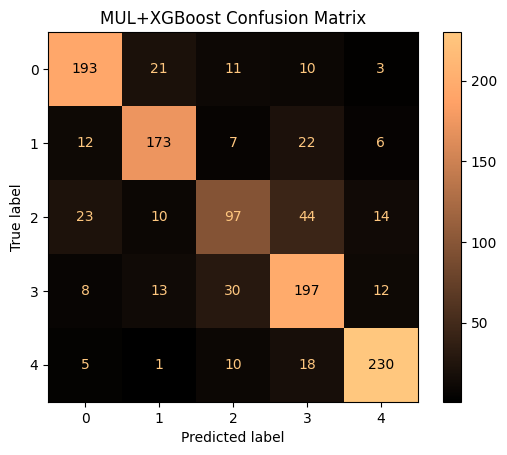

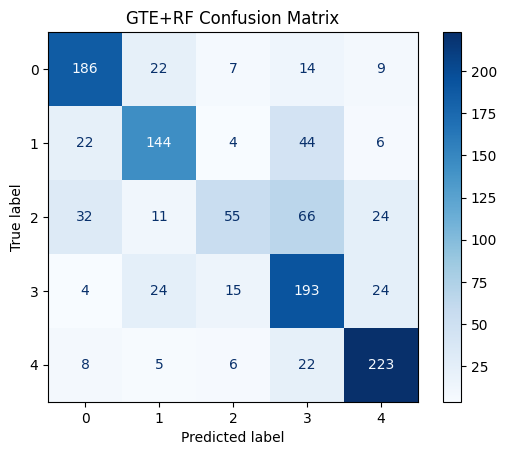

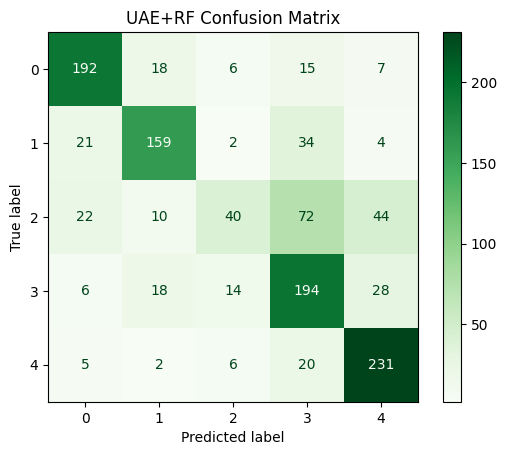

In [50]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt

classes = np.unique(y_test_5)
cm_gte =RF_gte_cm5
cm_mul = xg_mul_cm5
cm_uae = RF_uae_cm5

# Create a ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mul, display_labels=classes)
disp.plot(cmap=plt.cm.copper)
plt.title("MUL+XGBoost Confusion Matrix")
plt.show()

# Create a ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gte, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("GTE+RF Confusion Matrix")
plt.show()

# Create a ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_uae, display_labels=classes)
disp.plot(cmap=plt.cm.Greens)
plt.title("UAE+RF Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
con = confusion_matrix(y_test_5, xg_bge_y_pred5)
print(con)

[[51  6  1  2  0]
 [ 3 37  2  2  1]
 [10  5 24 19  4]
 [ 3  3  5 44  3]
 [ 0  0  2  6 60]]


# Four Classes

##### Read Dataset and Embed Sentence

In [9]:
# Read dataset 
humor_4class_path = "datasets/Humour_style_4classes.xlsx" 
x_train_4, x_test_4, y_train_4, y_test_4 = read_dataset(humor_4class_path)

In [ ]:
# BGE Embedding Model
x_train_4_bge, x_test_4_bge = BGE(x_train_4), BGE(x_test_4)

# GTE Embedding Model
x_train_4_gte, x_test_4_gte = GTE(x_train_4), GTE(x_test_4)

# UAE Embedding Model
x_train_4_uae, x_test_4_uae = UAE(x_train_4), UAE(x_test_4)

# MRL Embedding Model
x_train_4_mrl, x_test_4_mrl = MRL(x_train_4), MRL(x_test_4)

# ALI Embedding Model
x_train_4_ali, x_test_4_ali = ALI(x_train_4), ALI(x_test_4)

# MUL Embedding Model
x_train_4_mul, x_test_4_mul = MUL(x_train_4), MUL(x_test_4)


##### Random Forest Implementation

In [ ]:
# Training, Validation and prediction Using Random Forest
RF_bge_classifier4, RF_bge_cv_scores4,RF_bge_cm4 = randomforest(x_train_4_bge, y_train_4)
RF_bge_y_pred4, RF_bge_class_report4             = prediction(RF_bge_classifier4, x_test_4_bge, y_test_4)

RF_gte_classifier4, RF_gte_cv_scores4,RF_gte_cm4 = randomforest(x_train_4_gte, y_train_4)
RF_gte_y_pred4, RF_gte_class_report4             = prediction(RF_gte_classifier4, x_test_4_gte, y_test_4)

RF_uae_classifier4, RF_uae_cv_scores4,RF_uae_cm4 = randomforest(x_train_4_uae,y_train_4)
RF_uae_y_pred4, RF_uae_class_report4             = prediction(RF_uae_classifier4,x_test_4_uae, y_test_4)

RF_mrl_classifier4, RF_mrl_cv_scores4,RF_mrl_cm4 = randomforest(x_train_4_mrl,y_train_4)
RF_mrl_y_pred4, RF_mrl_class_report4             = prediction(RF_mrl_classifier4,x_test_4_mrl, y_test_4)

RF_ali_classifier4, RF_ali_cv_scores4,RF_ali_cm4 = randomforest(x_train_4_ali,y_train_4)
RF_ali_y_pred4, RF_ali_class_report4             = prediction(RF_ali_classifier4,x_test_4_ali, y_test_4)

RF_mul_classifier4, RF_mul_cv_scores4,RF_mul_cm4 = randomforest(x_train_4_mul,y_train_4)
RF_mul_y_pred4, RF_mul_class_report4             = prediction(RF_mul_classifier4,x_test_4_mul, y_test_4)


# Save Report
RF_bge_result_4= save_results(y_test_4,RF_bge_y_pred4)
RF_bge_result_4.to_csv('models_results/RF_bge_4classes.csv', index=False)              #Prediction Result
RF_bge_cv_scores4.to_csv('cross_validation_results/RF_bge_4classes.csv', index=False)  #Cross Validation Result

RF_gte_result_4 = save_results(y_test_4,RF_gte_y_pred4)
RF_gte_result_4.to_csv('models_results/RF_gte_4classes.csv', index=False)              #Prediction Result
RF_gte_cv_scores4.to_csv('cross_validation_results/RF_gte_4classes.csv', index=False)  #Cross Validation Result

RF_uae_result_4 = save_results(y_test_4,RF_uae_y_pred4)
RF_uae_result_4.to_csv('models_results/RF_uae_4classes.csv', index=False)              #Prediction Result
RF_uae_cv_scores4.to_csv('cross_validation_results/RF_uae_4classes.csv', index=False)  #Cross Validation Result

RF_mrl_result_4 = save_results(y_test_4,RF_mrl_y_pred4)
RF_mrl_result_4.to_csv('models_results/RF_mrl_4classes.csv', index=False)              #Prediction Result
RF_mrl_cv_scores4.to_csv('cross_validation_results/RF_mrl_4classes.csv', index=False)  #Cross Validation Result

RF_ali_result_4 = save_results(y_test_4,RF_ali_y_pred4)
RF_ali_result_4.to_csv('models_results/RF_ali_4classes.csv', index=False)              #Prediction Result
RF_ali_cv_scores4.to_csv('cross_validation_results/RF_ali_4classes.csv', index=False)  #Cross Validation Result

RF_mul_result_4 = save_results(y_test_4,RF_mul_y_pred4)
RF_mul_result_4.to_csv('models_results/RF_mul_4classes.csv', index=False)              #Prediction Result
RF_mul_cv_scores4.to_csv('cross_validation_results/RF_mul_4classes.csv', index=False)  #Cross Validation Result


# Evaluation Report
print(f'RF BGE: Cross Val {RF_bge_cv_scores4}\n {RF_bge_class_report4}')
print(f'RF GTE: Cross Val {RF_gte_cv_scores4}\n {RF_gte_class_report4}')

##### XGBOOST Implementation

In [ ]:
# XGBOOST
xg_bge_classifier4, xg_bge_cv_scores4,xg_bge_cm4 = XGBoost(x_train_4_bge, y_train_4, 4)
xg_bge_y_pred4,  xg_bge_class_report4            = prediction(xg_bge_classifier4, x_test_4_bge, y_test_4)

xg_gte_classifier4, xg_gte_cv_scores4,xg_gte_cm4 = XGBoost(x_train_4_gte, y_train_4, 4)
xg_gte_y_pred4, xg_gte_class_report4             = prediction(xg_gte_classifier4, x_test_4_gte, y_test_4)

xg_uae_classifier4, xg_uae_cv_scores4,xg_uae_cm4 = XGBoost(x_train_4_uae,y_train_4,4)
xg_uae_y_pred4, xg_uae_class_report4             = prediction(xg_uae_classifier4, x_test_4_uae, y_test_4)

xg_mrl_classifier4, xg_mrl_cv_scores4,xg_mrl_cm4 = XGBoost(x_train_4_mrl,y_train_4,4)
xg_mrl_y_pred4, xg_mrl_class_report4             = prediction(xg_mrl_classifier4, x_test_4_mrl, y_test_4)

xg_ali_classifier4, xg_ali_cv_scores4,xg_ali_cm4 = XGBoost(x_train_4_ali,y_train_4,4)
xg_ali_y_pred4, xg_ali_class_report4             = prediction(xg_ali_classifier4, x_test_4_ali, y_test_4)

xg_mul_classifier4, xg_mul_cv_scores4,xg_mul_cm4 = XGBoost(x_train_4_mul,y_train_4,4)
xg_mul_y_pred4, xg_mul_class_report4             = prediction(xg_mul_classifier4, x_test_4_mul, y_test_4)


# Save Report
xg_bge_result_4= save_results(y_test_4, xg_bge_y_pred4)
xg_bge_result_4.to_csv('models_results/XG_bge_4classes.csv', index=False)
xg_bge_cv_scores4.to_csv('cross_validation_results/XG_bge_4classes.csv', index=False)  #Cross Validation Result

xg_gte_result_4 = save_results(y_test_4, xg_gte_y_pred4)
xg_gte_result_4.to_csv('models_results/XG_gte_4classes.csv', index=False)
xg_gte_cv_scores4.to_csv('cross_validation_results/XG_gte_4classes.csv', index=False)  #Cross Validation Result

xg_uae_result_4 = save_results(y_test_4, xg_uae_y_pred4)
xg_uae_result_4.to_csv('models_results/XG_uae_4classes.csv', index=False)
xg_uae_cv_scores4.to_csv('cross_validation_results/XG_uae_4classes.csv', index=False)  #Cross Validation Result

xg_mrl_result_4= save_results(y_test_4, xg_mrl_y_pred4)
xg_mrl_result_4.to_csv('models_results/XG_mrl_4classes.csv', index=False)
xg_mrl_cv_scores4.to_csv('cross_validation_results/XG_mrl_4classes.csv', index=False)  #Cross Validation Result

xg_ali_result_4 = save_results(y_test_4, xg_ali_y_pred4)
xg_ali_result_4.to_csv('models_results/XG_ali_4classes.csv', index=False)
xg_ali_cv_scores4.to_csv('cross_validation_results/XG_ali_4classes.csv', index=False)  #Cross Validation Result

xg_mul_result_4 = save_results(y_test_4, xg_mul_y_pred4)
xg_mul_result_4.to_csv('models_results/XG_mul_4classes.csv', index=False)
xg_mul_cv_scores4.to_csv('cross_validation_results/XG_mul_4classes.csv', index=False)  #Cross Validation Result


# Evaluation Report
print(f'XGBoost BGE: Cross Val {xg_bge_cv_scores4}\n {xg_bge_class_report4}')
print(f'XGBoost GTE: Cross Val {xg_gte_cv_scores4}\n {xg_gte_class_report4}')

XGBoost BGE: Cross Val                     0                   1                   2  \
0            Accuracy           Precision              Recall   
1   0.782051282051282  0.7829222533629828  0.7671280108780109   
2  0.8034188034188035  0.8118857092386503  0.7831861986945992   
3  0.7478632478632479  0.7601631711899068  0.7131104411188416   
4  0.7777777777777778  0.7968135091397257  0.7570332489892908   
5  0.8034188034188035  0.8119605735880756  0.7830142046721733   
6   0.782905982905983  0.7927490433038683  0.7606944208705831   

                    3  
0            F1-score  
1  0.7737562562397038  
2   0.794799694236125  
3  0.7295446726196848  
4  0.7716984691072691  
5  0.7949140760294702  
6  0.7729426336464507  
               precision    recall  f1-score   support

           0       0.80      0.73      0.77        60
           1       0.72      0.73      0.73        45
           2       0.80      0.85      0.82       120
           3       0.89      0.84      0.86   

In [10]:
# MUL Embedding Model
x_train_4_mul, x_test_4_mul = MUL(x_train_4), MUL(x_test_4)
RF_mul_classifier4, RF_mul_cv_scores4,RF_mul_cm4 = randomforest(x_train_4_mul,y_train_4)
RF_mul_y_pred4, RF_mul_class_report4             = prediction(RF_mul_classifier4,x_test_4_mul, y_test_4)

In [12]:
import pickle

# When saving
with open('random_forest_4classes.pkl', 'wb') as f:
    pickle.dump(RF_mul_classifier4, f, protocol=4)

# Two Class Classification

##### Read dataset and Embed Text

In [11]:
# Read dataset 
train_2class_path = "datasets/af_ag_train_1463.csv" 
test_2class_path  = "datasets/af_ag_test_1463.csv" 

x_train_2, x_test_2, y_train_2, y_test_2 = read_train_test_dataset(train_2class_path, test_2class_path)

In [ ]:
# BGE Embedding Model
x_train_2_bge, x_test_2_bge = BGE(x_train_2), BGE(x_test_2)

# GTE Embedding Model
x_train_2_gte, x_test_2_gte = GTE(x_train_2), GTE(x_test_2)

# UAE Embedding Model
x_train_2_uae, x_test_2_uae = UAE(x_train_2), UAE(x_test_2)

# MRL Embedding Model
x_train_2_mrl, x_test_2_mrl = MRL(x_train_2), MRL(x_test_2)

# ALI Embedding Model
x_train_2_ali, x_test_2_ali = ALI(x_train_2), ALI(x_test_2)

# MUL Embedding Model
x_train_2_mul, x_test_2_mul = MUL(x_train_2), MUL(x_test_2)

##### Random Forest Implementation

In [ ]:
# Random Forest
RF_bge_classifier2, RF_bge_cv_scores2,RF_bge_cm2 = randomforest(x_train_2_bge,y_train_2)
RF_bge_y_pred2, RF_bge_class_report2             = prediction(RF_bge_classifier2, x_test_2_bge,y_test_2)

RF_gte_classifier2, RF_gte_cv_scores2,RF_gte_cm2 = randomforest(x_train_2_gte,y_train_2)
RF_gte_y_pred2, RF_gte_class_report2             = prediction(RF_gte_classifier2,x_test_2_gte, y_test_2)

RF_uae_classifier2, RF_uae_cv_scores2,RF_uae_cm2 = randomforest(x_train_2_uae,y_train_2)
RF_uae_y_pred2, RF_uae_class_report2             = prediction(RF_uae_classifier2,x_test_2_uae, y_test_2)

RF_mrl_classifier2, RF_mrl_cv_scores2,RF_mrl_cm2 = randomforest(x_train_2_mrl,y_train_2)
RF_mrl_y_pred2, RF_mrl_class_report2             = prediction(RF_mrl_classifier2,x_test_2_mrl, y_test_2)

RF_ali_classifier2, RF_ali_cv_scores2,RF_ali_cm2 = randomforest(x_train_2_ali,y_train_2)
RF_ali_y_pred2, RF_ali_class_report2             = prediction(RF_ali_classifier2,x_test_2_ali, y_test_2)

RF_mul_classifier2, RF_mul_cv_scores2,RF_mul_cm2 = randomforest(x_train_2_mul,y_train_2)
RF_mul_y_pred2, RF_mul_class_report2             = prediction(RF_mul_classifier2,x_test_2_mul, y_test_2)


# Save Report
RF_bge_result_2= save_results(y_test_2,RF_bge_y_pred2)
RF_bge_result_2.to_csv('models_results/RF_bge_2classes.csv', index=False)              #Prediction Result
RF_bge_cv_scores2.to_csv('cross_validation_results/RF_bge_2classes.csv', index=False)  #Cross Validation Result

RF_gte_result_2 = save_results(y_test_2,RF_gte_y_pred2)
RF_gte_result_2.to_csv('models_results/RF_gte_2classes.csv', index=False)              #Prediction Result
RF_gte_cv_scores2.to_csv('cross_validation_results/RF_gte_2classes.csv', index=False)  #Cross Validation Result

RF_uae_result_2 = save_results(y_test_2,RF_uae_y_pred2)
RF_uae_result_2.to_csv('models_results/RF_uae_2classes.csv', index=False)              #Prediction Result
RF_uae_cv_scores2.to_csv('cross_validation_results/RF_uae_2classes.csv', index=False)  #Cross Validation Result

RF_mrl_result_2 = save_results(y_test_2,RF_mrl_y_pred2)
RF_mrl_result_2.to_csv('models_results/RF_mrl_2classes.csv', index=False)              #Prediction Result
RF_mrl_cv_scores2.to_csv('cross_validation_results/RF_mrl_2classes.csv', index=False)  #Cross Validation Result

RF_ali_result_2 = save_results(y_test_2,RF_ali_y_pred2)
RF_ali_result_2.to_csv('models_results/RF_ali_2classes.csv', index=False)              #Prediction Result
RF_ali_cv_scores2.to_csv('cross_validation_results/RF_ali_2classes.csv', index=False)  #Cross Validation Result

RF_mul_result_2 = save_results(y_test_2,RF_mul_y_pred2)
RF_mul_result_2.to_csv('models_results/RF_mul_2classes.csv', index=False)              #Prediction Result
RF_mul_cv_scores2.to_csv('cross_validation_results/RF_mul_2classes.csv', index=False)  #Cross Validation Result           


# Evaluation Report
print(f'RF BGE: Cross Val {RF_bge_cv_scores2}\n {RF_bge_class_report2}')
print(f'RF GTE: Cross Val {RF_gte_cv_scores2}\n {RF_gte_class_report2}')

RF BGE: Cross Val                     0                   1                   2  \
0            Accuracy           Precision              Recall   
1  0.7111111111111111  0.7169471153846154  0.6826923076923077   
2  0.6888888888888889  0.7107142857142856  0.6492914979757085   
3  0.7666666666666667  0.7804232804232805  0.7413967611336032   
4  0.7303370786516854  0.7234848484848485  0.7146569646569647   
5   0.797752808988764           0.8228125  0.7684511434511434   
6  0.7389513108614232  0.7508764060014059  0.7112977349819454   

                    3  
0            F1-score  
1  0.6848060344827586  
2  0.6438665912945166  
3  0.7471571906354515  
4  0.7174603174603176  
5  0.7772525027808675  
6  0.7141085273307823  
               precision    recall  f1-score   support

           0       0.81      0.55      0.65        62
           1       0.64      0.86      0.74        58

    accuracy                           0.70       120
   macro avg       0.73      0.71      0.69       

##### XGBOOST Implementation

In [ ]:
# XGBOOST
xg_bge_classifier2, xg_bge_cv_scores2,xg_bge_cm2 = XGBoost(x_train_2_bge,y_train_2,2)
xg_bge_y_pred2, xg_bge_class_report2             = prediction(xg_bge_classifier2, x_test_2_bge, y_test_2)

xg_gte_classifier2, xg_gte_cv_scores2,xg_gte_cm2 = XGBoost(x_train_2_gte,y_train_2,2)
xg_gte_y_pred2, xg_gte_class_report2             = prediction(xg_gte_classifier2,x_test_2_gte, y_test_2)

xg_uae_classifier2, xg_uae_cv_scores2,xg_uae_cm2 = XGBoost(x_train_2_uae,y_train_2,2)
xg_uae_y_pred2, xg_uae_class_report2             = prediction(xg_uae_classifier2, x_test_2_uae, y_test_2)

xg_mrl_classifier2, xg_mrl_cv_scores2,xg_mrl_cm2 = XGBoost(x_train_2_mrl,y_train_2,2)
xg_mrl_y_pred2, xg_mrl_class_report2             = prediction(xg_mrl_classifier2, x_test_2_mrl, y_test_2)

xg_ali_classifier2, xg_ali_cv_scores2,xg_ali_cm2 = XGBoost(x_train_2_ali,y_train_2,2)
xg_ali_y_pred2, xg_ali_class_report2             = prediction(xg_ali_classifier2, x_test_2_ali, y_test_2)

xg_mul_classifier2, xg_mul_cv_scores2,xg_mul_cm2 = XGBoost(x_train_2_mul,y_train_2,2)
xg_mul_y_pred2, xg_mul_class_report2             = prediction(xg_mul_classifier2, x_test_2_mul, y_test_2)


# Save Report
xg_bge_result_2= save_results(y_test_2, xg_bge_y_pred2)
xg_bge_result_2.to_csv('models_results/XG_bge_2classes.csv', index=False)
xg_bge_cv_scores2.to_csv('cross_validation_results/XG_bge_2classes.csv', index=False)  #Cross Validation Result

xg_gte_result_2 = save_results(y_test_2, xg_gte_y_pred2)
xg_gte_result_2.to_csv('models_results/XG_gte_2classes.csv', index=False)
xg_gte_cv_scores2.to_csv('cross_validation_results/XG_gte_2classes.csv', index=False)  #Cross Validation Result

xg_uae_result_2 = save_results(y_test_2, xg_uae_y_pred2)
xg_uae_result_2.to_csv('models_results/XG_uae_2classes.csv', index=False)
xg_uae_cv_scores2.to_csv('cross_validation_results/XG_uae_2classes.csv', index=False)  #Cross Validation Result

xg_mrl_result_2= save_results(y_test_2, xg_mrl_y_pred2)
xg_mrl_result_2.to_csv('models_results/XG_mrl_2classes.csv', index=False)
xg_mrl_cv_scores2.to_csv('cross_validation_results/XG_mrl_2classes.csv', index=False)  #Cross Validation Result

xg_ali_result_2 = save_results(y_test_2, xg_ali_y_pred2)
xg_ali_result_2.to_csv('models_results/XG_ali_2classes.csv', index=False)
xg_ali_cv_scores2.to_csv('cross_validation_results/XG_ali_2classes.csv', index=False)  #Cross Validation Result

xg_mul_result_2 = save_results(y_test_2, xg_mul_y_pred2)
xg_mul_result_2.to_csv('models_results/XG_mul_2classes.csv', index=False)
xg_mul_cv_scores2.to_csv('cross_validation_results/XG_mul_2classes.csv', index=False)  #Cross Validation Result


# Evaluation Report
print(f'XGBoost BGE: Cross Val {xg_bge_cv_scores2}\n {xg_bge_class_report2}')
print(f'XGBoost GTE: Cross Val {xg_gte_cv_scores2}\n {xg_gte_class_report2}')

XGBoost BGE: Cross Val                     0                   1                   2  \
0            Accuracy           Precision              Recall   
1  0.7666666666666667  0.7736009044657999  0.7449392712550607   
2  0.6666666666666666  0.6628605769230769  0.6371457489878543   
3  0.7888888888888889  0.7990390050876202  0.7677125506072875   
4  0.7191011235955056  0.7127551020408163  0.7167359667359667   
5   0.651685393258427  0.6389830508474577  0.6278586278586279   
6   0.718601747815231  0.7174477278729542  0.6988784330889594   

                    3  
0            F1-score  
1  0.7503632281072514  
2  0.6363146551724138  
3  0.7741381587637035  
4  0.7138999614247139  
5  0.6290170767782708  
6  0.7007466160492706  
               precision    recall  f1-score   support

           0       0.76      0.66      0.71        62
           1       0.68      0.78      0.73        58

    accuracy                           0.72       120
   macro avg       0.72      0.72      0.72  

In [13]:
# MUL Embedding Model
x_train_2_mul, x_test_2_mul = MUL(x_train_2), MUL(x_test_2)
RF_mul_classifier2, RF_mul_cv_scores2,RF_mul_cm2 = randomforest(x_train_2_mul,y_train_2)
RF_mul_y_pred2, RF_mul_class_report2             = prediction(RF_mul_classifier2,x_test_2_mul, y_test_2)


In [14]:
import pickle

# When saving
with open('random_forest_2classes.pkl', 'wb') as f:
    pickle.dump(RF_mul_classifier2, f, protocol=4)

# When loading in your Flask app
#with open(model_path, 'rb') as f:
#    model_data = pickle.load(f)

# Two Model Pipeline

In [15]:
def two_model_pipeline(model4, model2, x_test4, x_test2, y_test_4):
    model4_pred, model4_pred_report  = prediction(model4, x_test4, y_test_4)
    model4_pred_array = np.array(model4_pred)

    # Identify instances classified as affiliative/aggressive
    aff_agg_mask = (model4_pred_array == 2)

    # Apply second model only to these instances
    x_test_filtered = [x for x, mask in zip(x_test2, aff_agg_mask) if mask]
    model2_pred = model2.predict(x_test_filtered)

    # Combine results
    final_pred = [4 if pred == 3 else pred for pred in model4_pred]
    model2_pred = [2 if p == 0 else 3 for p in model2_pred]

    # Update final_pred with model2_pred results
    pred2_index = 0
    for i, mask in enumerate(aff_agg_mask):
        if mask:
            final_pred[i] = model2_pred[pred2_index]
            pred2_index += 1

    return final_pred



In [16]:
two_model_predict = two_model_pipeline(RF_mul_classifier4, RF_mul_classifier2, x_test_4_mul, x_test_4_mul, y_test_4)

In [17]:
two_model_results = save_results(y_test_5,two_model_predict)
print(two_model_results)

#two_model_results.to_csv("two_model_pipeline_results/XG_mul_XG_mul.csv", index=True)

              precision  recall  f1-score  support
0                 0.942   0.817     0.875     60.0
1                 0.867   0.578     0.693     45.0
2                 0.623   0.613     0.618     62.0
3                 0.551   0.845     0.667     58.0
4                 0.951   0.853     0.899     68.0
accuracy            NaN     NaN     0.751      NaN
macro avg         0.787   0.741     0.750    293.0
weighted avg      0.788   0.751     0.757    293.0


# Individual Joke Prediction

In [ ]:
def single_predict(example, embed_model, class_model, num_label):
    # Embedding 
    embedding = np.empty(0)
    if embed_model == "bge":
        embedding = BGE(example)
    elif embed_model == "gte":
        embedding = GTE(example)
    elif embed_model == "uae":
        embedding = UAE(example)
    elif embed_model == "mrl":
        embedding = MRL(example)
    elif embed_model == "ali":
        embedding = ALI(example)
    else:
        embedding = MUL(example)
    
    embedding = np.expand_dims(embedding, axis=0)

    # Classifiers
    if num_label == 5:
        if class_model == "rf" and embed_model == "bge":
            pred = RF_bge_classifier5.predict(embedding)
        elif class_model == "rf" and embed_model == "gte":
            pred = RF_gteclassifier5.predict(embedding)
        elif class_model == "xgb" and embed_model == "gte":
            pred = xg_gte_classifier5.predict(embedding)
        elif class_model == "xgb" and embed_model == "bge":
            pred = xg_bge_classifier5.predict(embedding)
        elif class_model == "rf" and embed_model == "mul":
            pred = RF_mul_classifier5.predict(embedding)
        elif class_model == "xgb" and embed_model == "mul":
            pred = xg_mul_classifier5.predict(embedding)
    elif num_label == 4:
        if class_model == "rf"and embed_model == "bge":
            pred = RF_bge_classifier4.predict(embedding)
        elif class_model == "rf" and embed_model == "gte":
            pred = RF_gte_classifier4.predict(embedding)
        elif class_model == "xgb" and embed_model == "bge":
            pred = xg_bge_classifier4.predict(embedding)
        elif class_model == "xgb" and embed_model == "gte":
            pred = xg_gte_classifier4.predict(embedding)
        elif class_model == "rf" and embed_model == "mul":
            pred = RF_mul_classifier4.predict(embedding)
        elif class_model == "xgb" and embed_model == "mul":
            pred = xg_mul_classifier4.predict(embedding)
    elif num_label == 2:
        if class_model == "rf"and embed_model == "bge":
            pred = RF_bge_classifier2.predict(embedding)
        elif class_model == "rf" and embed_model == "gte":
            pred = RF_gte_classifier2.predict(embedding)
        elif class_model == "xgb" and embed_model == "bge":
            pred = xg_bge_classifier2.predict(embedding)
        elif class_model == "xgb" and embed_model == "gte":
            pred = xg_gte_classifier2.predict(embedding)
        elif class_model == "rf" and embed_model == "mrl":
            pred = RF_mrl_classifier2.predict(embedding)
        elif class_model == "xgb" and embed_model == "mrl":
            pred = xg_mrl_classifier2.predict(embedding)
    
    return pred


In [ ]:
mapping5 = {
    0:"Self-enhancing",
    1:"Self-deprecating",
    2:"Affiliative",
    3:"Aggressive",
    4:"Neutral"
}
mapping4 = {
    0:"Self-enhancing",
    1:"Self-deprecating",
    2:"Affiliative/Aggressive",
    3:"Neutral",
}
mapping2 = {
    0:"Affiliative",
    1:"Aggressive",
}

user_input = """
The owner of X, formerly Twitter, posted the remarks on the platform in response to a video showing people aiming fireworks at police.
The prime minister's spokesperson said there was "no justification" for Mr Musk's comments, adding there was more that social media companies "can and should be doing".
Justice Minister Heidi Alexander also criticised the tech billionaire for his "totally unjustifiable" and "pretty deplorable" comments.
"""

predict_5 = single_predict(user_input, "mul", "rf", 5)
predict_4 = single_predict(user_input, "mul", "xgb", 4)

predict_2 = "None"
if int(predict_4) == 2:
    predict_2 = single_predict(user_input, "mrl", "xgb", 2) #2 class model

label5 = predict_5.item()    # Convert array to single value 
label4 = predict_4.item()    # Convert array to single value 
if predict_2 != "None":
    label2 = predict_2.item()    # Convert array to single value 
    label2 = mapping2[label2]
else:
    label2 = "Not Affiliative or Aggressive"


# Print the predicted label
print(f'User Input: "{user_input}\n 5 class Model prediction : {mapping5[label5]}\n 4 class Model prediction : {mapping4[label4]}')
print(f' 2 class Model prediction : {label2}')


User Input: "
The owner of X, formerly Twitter, posted the remarks on the platform in response to a video showing people aiming fireworks at police.
The prime minister's spokesperson said there was "no justification" for Mr Musk's comments, adding there was more that social media companies "can and should be doing".
Justice Minister Heidi Alexander also criticised the tech billionaire for his "totally unjustifiable" and "pretty deplorable" comments.

 5 class Model prediction : Neutral
 4 class Model prediction : Neutral
 2 class Model prediction : Not Affiliative or Aggressive
